In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib
import seaborn as sns

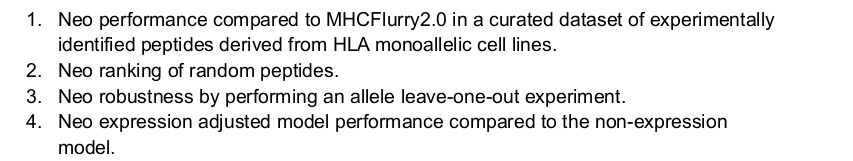

# 10% held out vs mcflurry 2.0

In [4]:
df_ten = pd.read_csv("data_validation/validation_10pct_hmf_vs_mcf_scores.csv",sep=",")
df_ten.head()

,Allele,Peptide,HmfRecaclMcfPresentationRank,Score,ScoreRank,Likelihood,LikelihoodRank,McfPresentationPercentile
0,A0101,AADLVEALY,0.000059,7.6314,0.000845,0.012062,0.000408,0.000154
1,A0101,AASYLDQISRY,0.003820,4.9801,0.004145,0.000274,0.007405,0.009103
2,A0101,ADMGHLKY,0.000358,6.2500,0.002494,0.000362,0.005963,0.004630
3,A0101,AIDEDVLRY,0.000021,12.2945,0.000006,0.132800,0.000055,0.000073
4,A0101,AIDLLKEIY,0.000220,8.2994,0.000605,0.015382,0.000249,0.000481


# TPR per threshold

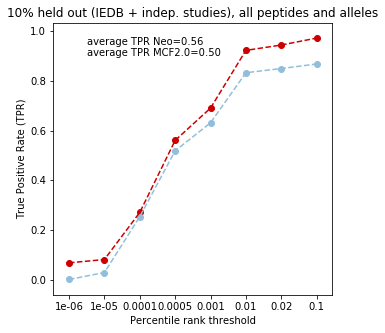

In [6]:
thresholds = [10**-6,0.00001,0.0001,0.0005,0.001,0.01,0.02,0.1]
total=df_ten.shape[0]
tprs_neo = [df_ten[df_ten["LikelihoodRank"]<t].shape[0] / total for t in thresholds]
tprs_mcf = [df_ten[df_ten["McfPresentationPercentile"]<t].shape[0] / total for t in thresholds]

fig,ax=plt.subplots(figsize=(5,5))
ax.plot(range(0,len(thresholds)),tprs_neo,color="#cc0000",ls="--")
ax.scatter(range(0,len(thresholds)),tprs_neo,color="#cc0000")

ax.plot(range(0,len(thresholds)),tprs_mcf,color="#91bfdb",ls="--")
ax.scatter(range(0,len(thresholds)),tprs_mcf,color="#91bfdb")

ax.set_xticks(range(0,len(thresholds)))
ax.set_xticklabels(thresholds)

ax.set_ylabel("True Positive Rate (TPR)")
ax.set_xlabel("Percentile rank threshold")
ax.set_title("10% held out (IEDB + indep. studies), all peptides and alleles")

ax.annotate(xy=(0.5,0.9),s=f"average TPR Neo={np.nanmean(tprs_neo):.2f}\naverage TPR MCF2.0={np.nanmean(tprs_mcf):.2f}")
plt.savefig(f'figures/neo_validation_mcf_10pct_held_out_all.pdf', dpi=800,bbox_inches="tight")

### Per allele lenght

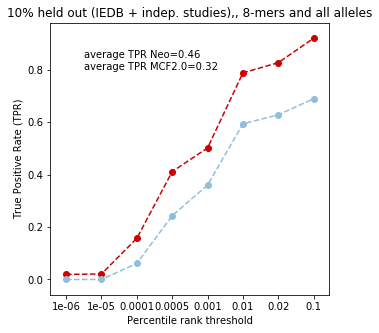

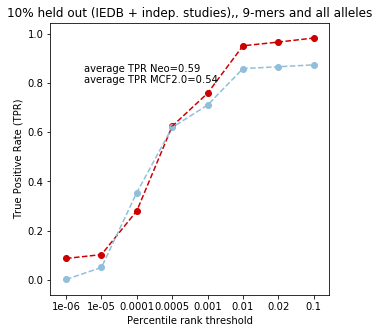

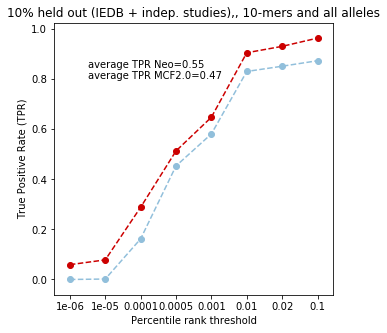

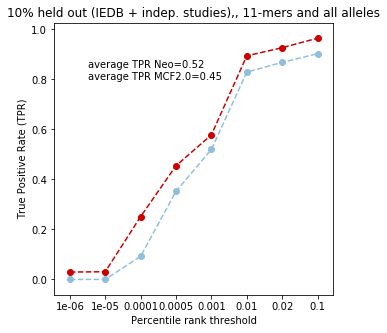

In [7]:
thresholds = [10**-6,0.00001,0.0001,0.0005,0.001,0.01,0.02,0.1]
for l in range(8,13,1):
    df_s = df_ten[df_ten["Peptide"].str.len()==l]
    total=df_s.shape[0]
    if total == 0:
        continue
    tprs_neo = [df_s[df_s["LikelihoodRank"]<t].shape[0] / total for t in thresholds]
    tprs_mcf = [df_s[df_s["McfPresentationPercentile"]<t].shape[0] / total for t in thresholds]

    fig,ax=plt.subplots(figsize=(5,5))
    ax.plot(range(0,len(thresholds)),tprs_neo,color="#cc0000",ls="--")
    ax.scatter(range(0,len(thresholds)),tprs_neo,color="#cc0000")

    ax.plot(range(0,len(thresholds)),tprs_mcf,color="#91bfdb",ls="--")
    ax.scatter(range(0,len(thresholds)),tprs_mcf,color="#91bfdb")

    ax.set_xticks(range(0,len(thresholds)))
    ax.set_xticklabels(thresholds)

    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_xlabel("Percentile rank threshold")
    ax.set_title(f"10% held out (IEDB + indep. studies),, {l}-mers and all alleles")

    ax.annotate(xy=(0.5,0.8),s=f"average TPR Neo={np.nanmean(tprs_neo):.2f}\naverage TPR MCF2.0={np.nanmean(tprs_mcf):.2f}")
    
    plt.savefig(f'figures/neo_validation_mcf_10pct_held_out_{l}.pdf', dpi=800,bbox_inches="tight")

-----

# Ranking of non-binders

In [9]:
df_negative = pd.read_csv("data_validation/neo_peptide_scores_cmb_02_rand_sherpa.csv",sep=",")
df_negative.head()

,Allele,Peptide,Source,Score,Rank,Likelihood,LikelihoodRank,FlankScore,UpFlank,DownFlank,PeptideLength,RowIndex
0,B8101,PRKDLIVM,NaN,-0.8152,0.084295,0.000009,0.060209,-0.3457,GKV,LKD,8,10
1,B8101,VSSTVPKM,NaN,-5.1867,0.343688,0.000000,0.686690,-0.1587,IWY,LVN,8,20
2,B8101,KIETLFYA,NaN,-9.5305,0.800611,0.000000,0.814333,-0.2708,GMQ,MVT,8,30
3,B8101,ACWAIKEL,NaN,3.4846,0.011000,0.000030,0.019000,-0.0743,VAH,DGS,8,40
4,B8101,ILMFFNKD,NaN,-6.9171,0.526361,0.000000,0.748646,-0.1705,DQI,LRR,8,50


In [10]:
len(df_negative["Allele"].unique())

25

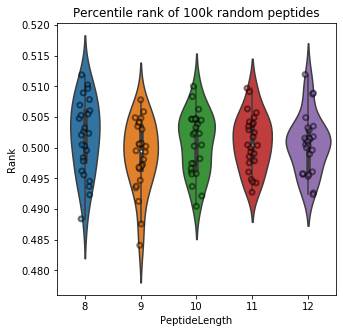

In [12]:
summ_l=df_negative.groupby(["Allele","PeptideLength"],as_index=False).agg(mean_lk=("Rank",np.nanmean),median_lk=("Rank",np.nanmedian))
fig,ax=plt.subplots(figsize=(5,5))
sns.violinplot(x="PeptideLength",y="median_lk",data=summ_l)
sns.stripplot(x="PeptideLength",y="median_lk",data=summ_l,edgecolor="black",alpha=0.5,linewidth=2)
ax.set_ylabel("Rank")
ax.set_title("Percentile rank of 100k random peptides")
plt.savefig(f'figures/negative_per_lenght_rank.pdf', dpi=800,bbox_inches="tight")

----

# One leave one out

In [18]:
df_lv= pd.read_csv("data_validation/validation_leave_out_allele_scores.csv",sep=",")

In [19]:
len(df_lv["Allele"].unique())

116

In [34]:
def get_performance_002(grp):
    return np.nansum(grp<0.02) / len(grp)


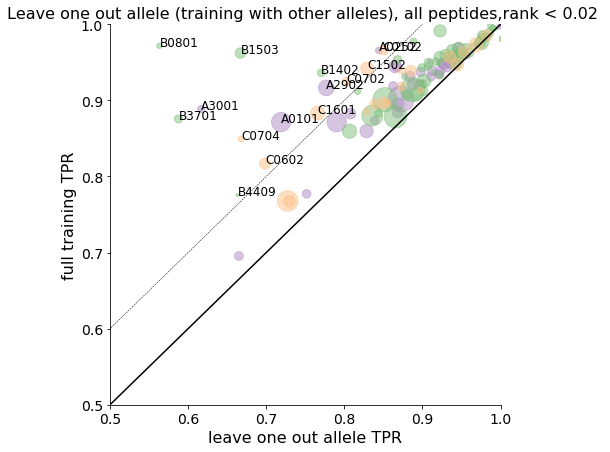

In [35]:
performance_002=df_lv.groupby(["Allele"]).agg({"LikelihoodRankLoa":get_performance_002,"LikelihoodRankSelf":get_performance_002,"Peptide":"count"})
fig,ax = plt.subplots(figsize=(7,7))
d_colors = {"A":"#af8dc3","B":"#7fbf7b","C":"#fdc086"}
performance_002["color"] = performance_002.apply(lambda row: d_colors[row.name[0]],axis=1)
ax.scatter(performance_002["LikelihoodRankLoa"],performance_002["LikelihoodRankSelf"],s=performance_002["Peptide"]/25,color=performance_002["color"],alpha=0.5)
for i,r in performance_002.iterrows():
    if r["LikelihoodRankSelf"] - r["LikelihoodRankLoa"] >0.1 :
        ax.annotate(xy=(r["LikelihoodRankLoa"],r["LikelihoodRankSelf"]),s=i,fontsize=12)
ax.set_ylabel("full training TPR",fontsize=16)
ax.set_xlabel("leave one out allele TPR",fontsize=16)
ax.set_xlim(0.5,1.0)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(0.5,1.0)
ax.plot([0.0,1.0],ls="-",color="black",lw=1.5)
ax.plot([0.1,1.1],ls="--",color="black",lw=0.5)
ax.set_title("Leave one out allele (training with other alleles), all peptides,rank < 0.02 ",fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'figures/neo_validation_leave_one_out_full_002.pdf', dpi=800,bbox_inches="tight")


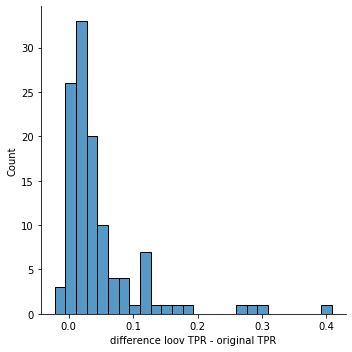

In [40]:
performance_002["diff"] = performance_002["LikelihoodRankSelf"] - performance_002["LikelihoodRankLoa"]
sns.displot(performance_002.rename(columns={"diff":"difference loov TPR - original TPR"})["difference loov TPR - original TPR"])

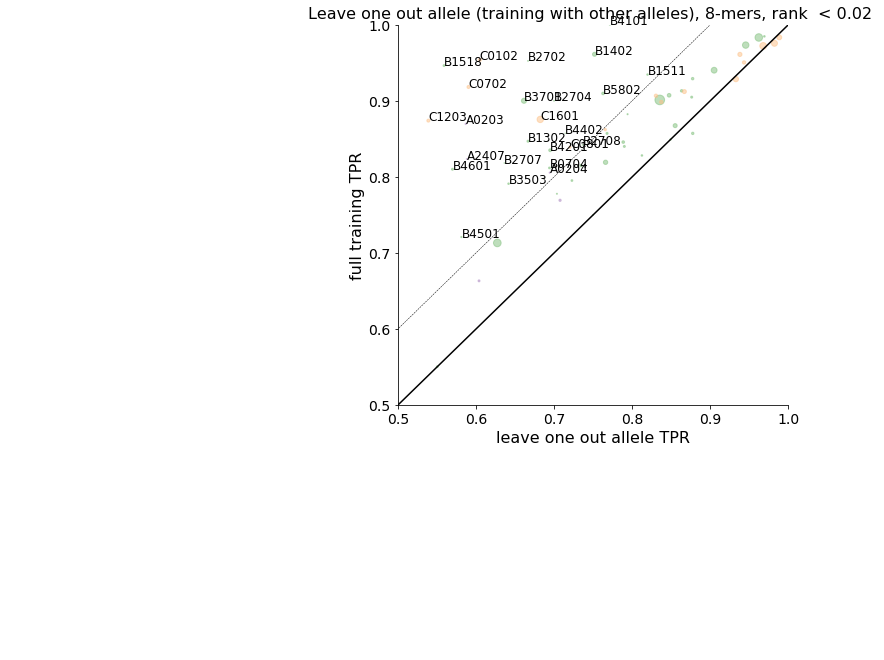

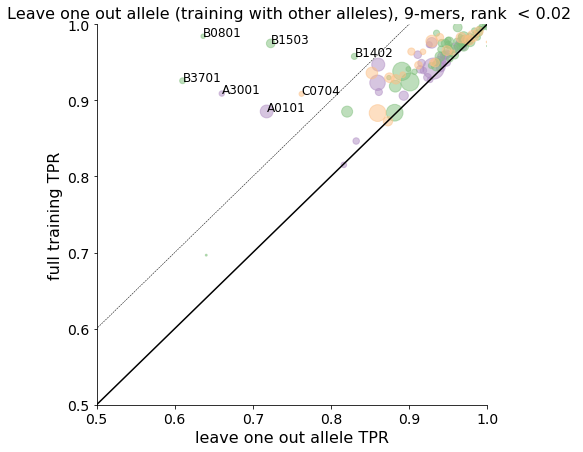

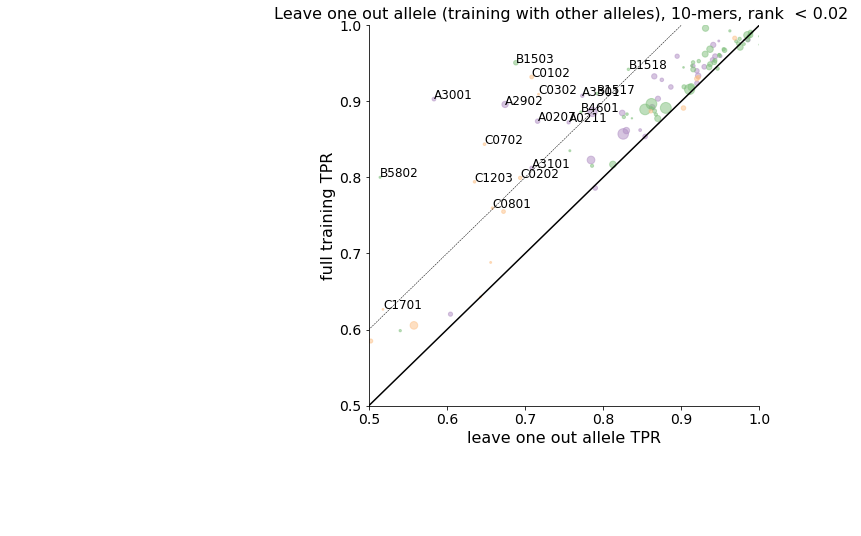

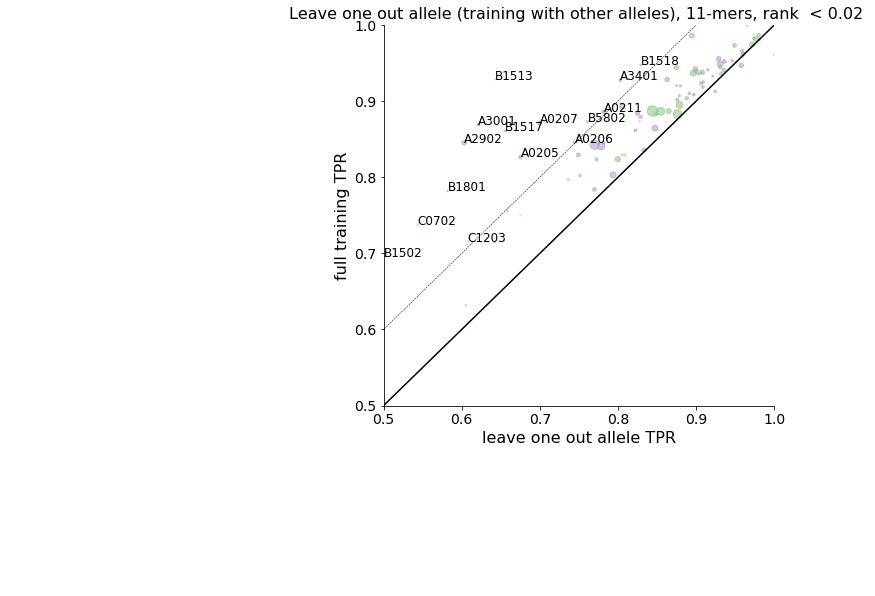

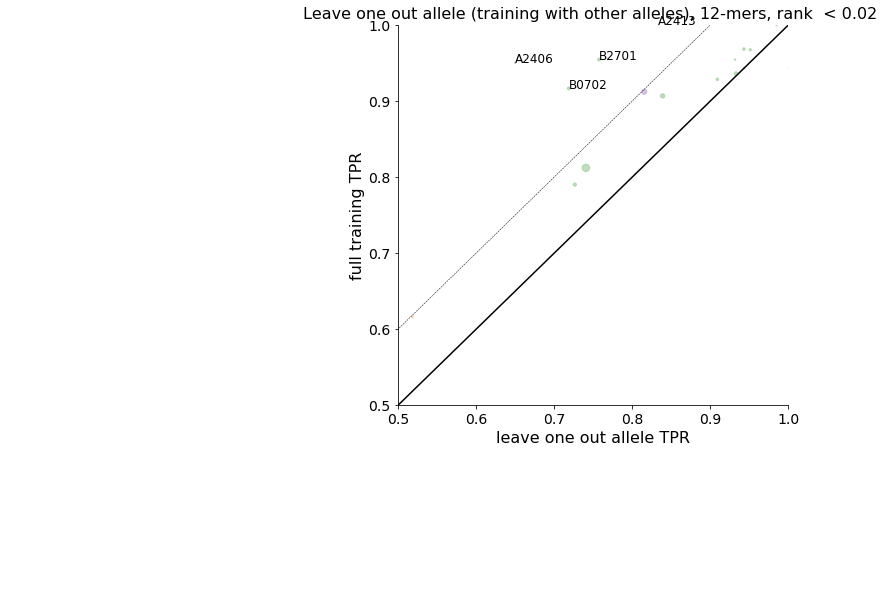

In [26]:

for l in range(8,13,1):
    performance_001=df_lv[df_lv["Peptide"].str.len()==l].groupby(["Allele"]).agg({"LikelihoodRankLoa":get_performance_002,"LikelihoodRankSelf":get_performance_002,"Peptide":"count"})
    
    fig,ax = plt.subplots(figsize=(7,7))
    d_colors = {"A":"#af8dc3","B":"#7fbf7b","C":"#fdc086"}
    performance_001["color"] = performance_001.apply(lambda row: d_colors[row.name[0]],axis=1)
    ax.scatter(performance_001["LikelihoodRankLoa"],performance_001["LikelihoodRankSelf"],s=performance_001["Peptide"]/25,color=performance_001["color"],alpha=0.5)
    for i,r in performance_001.iterrows():
        if r["LikelihoodRankSelf"] - r["LikelihoodRankLoa"] >0.1 :
            ax.annotate(xy=(r["LikelihoodRankLoa"],r["LikelihoodRankSelf"]),s=i,fontsize=12)
    ax.set_ylabel("full training TPR",fontsize=16)
    ax.set_xlabel("leave one out allele TPR",fontsize=16)
    
    ax.plot([0.0,1.0],ls="-",color="black",lw=1.5)
    ax.plot([0.1,1.1],ls="--",color="black",lw=0.5)
    ax.set_title(f"Leave one out allele (training with other alleles), {l}-mers, rank  < 0.02 ",fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim(0.5,1.0)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim(0.5,1.0)
    
    _=plt.savefig(f'figures/neo_validation_leave_one_out_{l}_002.pdf', dpi=800,bbox_inches="tight")
    


-----

# HLA-thena validation

In [30]:
hlathena = pd.read_csv("data_validation/hlathena_expression_comparison_scores.csv",sep=",").rename(columns={"LikelihoodRank.x":"LikelihoodRankExp","LikelihoodRank.y":"LikelihoodRank"})

### TPR per bin

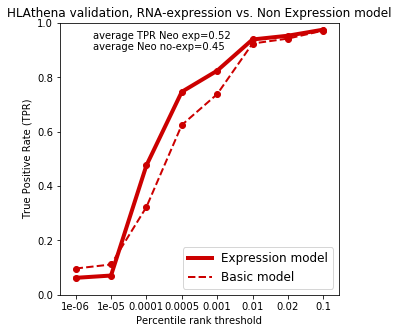

In [31]:
thresholds = [10**-6,0.00001,0.0001,0.0005,0.001,0.01,0.02,0.1]
total=hlathena.shape[0]
tprs_exp = [hlathena[hlathena["ExpressionLikelihoodRank"]<t].shape[0] / total for t in thresholds]
tprs_no_exp = [hlathena[hlathena["LikelihoodRank"]<t].shape[0] / total for t in thresholds]

fig,ax=plt.subplots(figsize=(5,5))
ax.plot(range(0,len(thresholds)),tprs_exp,color="#cc0000",lw=4)
ax.scatter(range(0,len(thresholds)),tprs_exp,color="#cc0000")
ax.plot(range(0,len(thresholds)),tprs_no_exp,color="#cc0000",lw=2,ls="--")
ax.scatter(range(0,len(thresholds)),tprs_no_exp,color="#cc0000")

ax.set_xticks(range(0,len(thresholds)))
ax.set_xticklabels(thresholds)

ax.set_ylabel("True Positive Rate (TPR)")
ax.set_xlabel("Percentile rank threshold")
ax.set_title("HLAthena validation, RNA-expression vs. Non Expression model")

markers = [plt.Line2D([0,0],[0,0],color="#cc0000", marker='',lw=4),plt.Line2D([0,0],[0,0],color="#cc0000", marker='',lw=2,ls="--")]
ax.legend(markers, ["Expression model","Basic model"], numpoints=1,fontsize=12,loc="lower right")
ax.annotate(xy=(0.5,0.9),s=f"average TPR Neo exp={np.nanmean(tprs_neo):.2f}\naverage Neo no-exp={np.nanmean(tprs_mcf):.2f}")
ax.set_ylim(0.0,1.0)
plt.savefig(f'figures/neo_validation_hlathena_exp.pdf', dpi=800,bbox_inches="tight")